# **Transfer Learning for Image Classification of Five Flower Classes**

### This notebook demonstrates the use of transfer learning for image classification. We will fine-tune the **ResNet50** model to classify five distinct classes of flowers.

### **Dataset**
The dataset was kindly provided by Vizuara AI Labs. You can access the Google Drive folder for the dataset here: [Vizuara AI Labs Dataset](https://drive.google.com/drive/folders/1BiqW9HEl3Ld-ik1LefD0YQFToRdrmQd1).




# Model Architecture:

### For this classification task, we adopted a transfer learning approach using the following architecture:

* Base Model: The pre-trained `ResNet50` model (trained on ImageNet) was used as the base for feature extraction.

* Transfer Learning Strategy: The layers of the `ResNet50` base model were frozen to preserve its learned weights.

* Custom Classifier Head: A new classification head was added on top of the frozen base, consisting of:

* A dense hidden layer with `256 units` and a `ReLU` activation function.

* A final output layer with `5 units`, corresponding to the five distinct flower classes.

In [ ]:
!pip install -q torchinfo

In [ ]:
import torch
import torchvision
from torchvision import datasets,transforms,models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
import time
import numpy as np
import pandas as pd
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

The 5-Flowers classification dataset can be downloaded from the link [here.](https://drive.google.com/drive/folders/1BiqW9HEl3Ld-ik1LefD0YQFToRdrmQd1)

In [ ]:
# Extract the dataset.
file = '5flowers-dataset.zip'
with zipfile.ZipFile(file, 'r') as zip:
    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

extraction...
Done!


In [ ]:
train_root = os.path.join("flowers","train")
valid_root = os.path.join("flowers","val")

In [ ]:
# We first get the mean and standard deviation of the data set if its not available
def get_mean_std(train_loader,img_size=(224,224),num_workers=2):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data,_ in train_loader:
        batch_mean += batch_data.mean(dim=(0,2,3)) # Pytorch dimensions = [B,C,H,W] = [0,1,2,3]
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0,2,3))
        #  the mean is calculated over the batch, height, and width dimensions.
        # The result will have a shape of (Channels,).
        # This means you'll get a single mean value for each channel.

    mean = batch_mean / len(train_loader)

    #Variance is the mean of the squares minus the square of the mean.
    var = (batch_mean_sqrd/len(train_loader)) - (mean ** 2)

    std = var ** 0.5

    print(f"Mean : {mean}, Std : {std}")
    return mean,std

In [ ]:
# We define the transformations and pre-processing required for the Training and Validation Dataset
img_size = (224,224)

preprocess = transforms.Compose([
    transforms.Resize(img_size,antialias=True),
    transforms.ToTensor()
])

In [ ]:
# Loading the Data with transformation i.e, converting the required size and Totensor
train_data_mean_calc = datasets.ImageFolder(root=train_root,transform=preprocess)
# Loading the Train_loader to get the mean and std for the dataset
train_loader_mean_calc = DataLoader(train_data_mean_calc,batch_size=32,shuffle=True,num_workers=2)

mean,std = get_mean_std(train_loader_mean_calc)

print(f"Dataset Mean : {mean}")
print(f"Dataset Std: {std}")


Mean : tensor([0.5876, 0.5401, 0.4701]), Std : tensor([0.3421, 0.3185, 0.3602])
Dataset Mean : tensor([0.5876, 0.5401, 0.4701])
Dataset Std: tensor([0.3421, 0.3185, 0.3602])


In [ ]:
# Pre-processing for Training DataSet
train_transform = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=0.4),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=(30,70),translate=(0.1,0.3),scale=(0.5,0.75))
    ], p=0.1), # This line will apply rotation, translation and Scaling 10% of the time for the given range
    transforms.Normalize(mean=mean,std=std)
])

# Pre-processing for Common and Validation Data Set
common_transform = transforms.Compose([
    preprocess,
    transforms.Normalize(mean=mean,std=std)

])

In [ ]:
#Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root = train_root, transform = train_transform)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root = valid_root, transform = common_transform)

In [ ]:
# We got the data, now we call the loader
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = 32,
    num_workers = 2
)
val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = 32,
    num_workers = 2
)

In [ ]:
train_data.classes

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

In [ ]:
class_mapping = {
    0: "Lilly",
    1: "Lotus",
    2: "Orchid",
    3: "Sunflower",
    4: "Tulip"
}

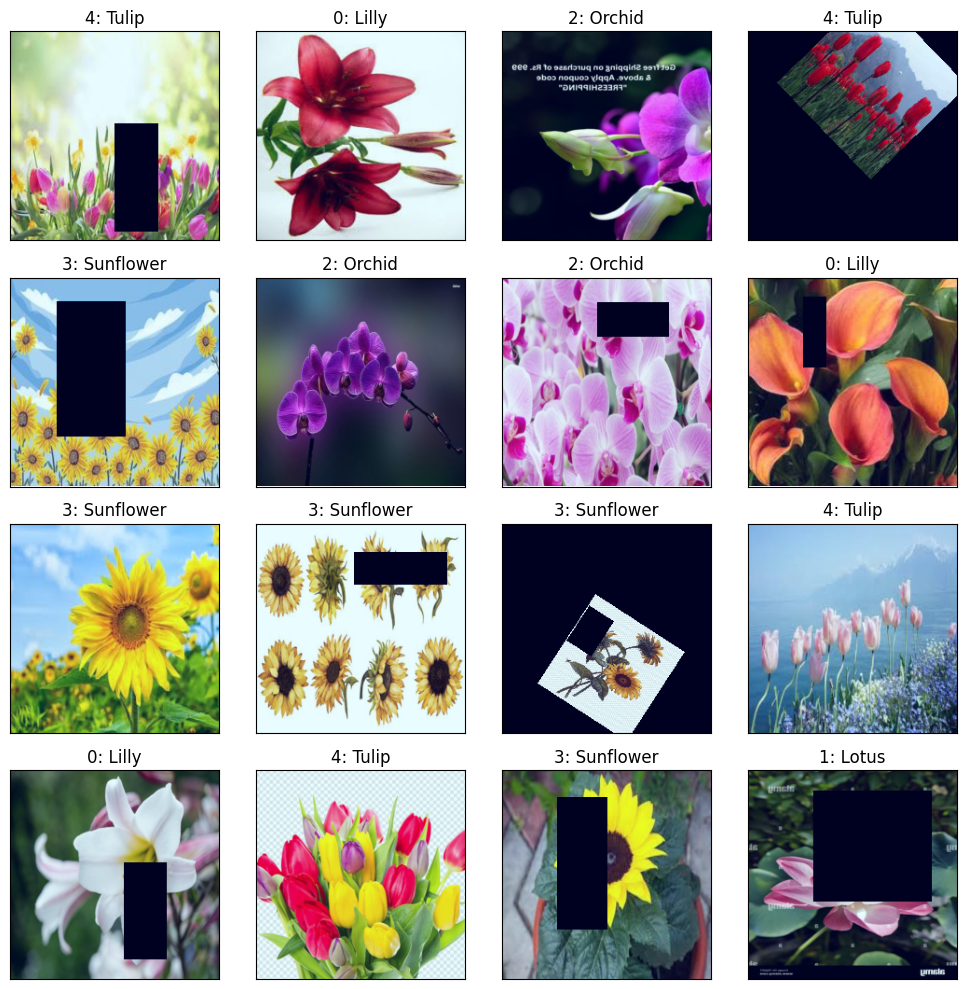

In [ ]:
# Visualizing the image
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

In [ ]:
# Get the training and valid data size
train_data_size = len(train_data)
val_data_size = len(val_data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available Device: {device}")

print(f"Number of training samples:   {train_data_size}")
print(f"Number of validation samples: {val_data_size}")


Available Device: cuda
Number of training samples:   4008
Number of validation samples: 1011


In [ ]:
resnet50 = models.resnet50(weights='DEFAULT')
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
# Print the model summary with dummy input variable
dummy_input = (32,3,224,224)
print(summary(resnet50,input_size=dummy_input))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [ ]:
# Freeze the model parameters
for params in resnet50.parameters():
    params.requires_grad = False

In [ ]:
# Changing the Final layer for fully connected classification head
fc_inputs = resnet50.fc.in_features # Get the number of input features for the final layer

# Define a new fully connected layer with custom architecture for classification
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,256), # Fully connected layer with 256 neurons
    nn.ReLU(),                 # ReLU Activation
    nn.Dropout(0.4),          # Applying dropout to prevent overfitting
    nn.Linear(256,5), # Output with number of classes as the output neurons
    nn.LogSoftmax(dim=1)        # LogSoftmax for multi-class classification (used with NLLLoss)
)

resnet50 = resnet50.to(device)

# Check to see the new classification head
print(summary(resnet50,input_size=dummy_input))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [ ]:
# Defining the loss
loss_func = nn.NLLLoss() # NLL Loss for Multi-class classification

# Define the learning rate
learning_rate = 0.01

# Define the Optimizer using Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(
    params = resnet50.parameters(), # Optimizing all parameters of resnet50 model
    lr = learning_rate,
    momentum = 0.9 # Momentum term to improve convergence and avoid local minima
)

In [ ]:
def train_and_validate(model,loss_func,optimizer,epochs):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1,epochs))

        # Set to Training Mode
        model.train()

        # Loss and Accuracy within each epoch
        train_loss = 0.0
        train_cp = 0.0 # Training Correct Predictions
        train_samples = 0.0

        valid_loss = 0.0
        valid_cp = 0.0 # Valid Correct Predictions
        valid_samples = 0.0

        for i, (inputs,labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean the existing gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute Loss
            loss = loss_func(outputs,labels)

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the BATCH and add it to the train_loss
            train_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(outputs.data,dim=1)
            train_samples += labels.shape[0]
            train_cp += (predictions==labels).sum().item()

            print("Batch number: {:03d}, Training Loss: {:.4f}, Accuracy: {:.4f}".format(i, train_loss, train_cp))

        # Validation - No Gradient Tracking Needed
        with torch.no_grad():
            # Set the model of eval mode
            model.eval()

            for j, (inputs,labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward Pass
                outputs = model(inputs)

                # Calculating the loss
                loss = loss_func(outputs,labels)

                # Calculating the validation loss
                valid_loss += loss.item()
                _,predictions_valid = torch.max(outputs.data,dim=1)
                valid_samples += labels.shape[0]
                valid_cp += (predictions_valid==labels).sum().item()

                print("Batch number: {:03d}, Valid Loss: {:.4f}, Accuracy: {:.4f}".format(j, valid_loss, valid_cp))

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            # Save if the model has the best valid accuracy till now
            torch.save(model,'best_model.pt')

        # Finding the average losses and accuracy
        avg_train_loss = train_loss/train_data_size
        avg_valid_loss = valid_loss/val_data_size

        training_accuracy = (train_cp/train_samples) * 100
        valid_accuracy = (valid_cp/valid_samples) * 100

        history.append([avg_train_loss,training_accuracy,avg_valid_loss,valid_accuracy])
        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, training_accuracy, avg_valid_loss, valid_accuracy, epoch_end-epoch_start))

    return model, history, best_epoch

In [ ]:
# Train the model.
dataset = 'flowers'
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Batch number: 000, Training Loss: 0.5044, Accuracy: 27.0000
Batch number: 001, Training Loss: 0.9197, Accuracy: 54.0000
Batch number: 002, Training Loss: 1.3409, Accuracy: 82.0000
Batch number: 003, Training Loss: 1.7981, Accuracy: 109.0000
Batch number: 004, Training Loss: 2.4502, Accuracy: 134.0000
Batch number: 005, Training Loss: 3.1595, Accuracy: 158.0000
Batch number: 006, Training Loss: 3.6912, Accuracy: 183.0000
Batch number: 007, Training Loss: 4.1899, Accuracy: 210.0000
Batch number: 008, Training Loss: 4.8455, Accuracy: 233.0000
Batch number: 009, Training Loss: 5.3622, Accuracy: 259.0000
Batch number: 010, Training Loss: 6.0204, Accuracy: 283.0000
Batch number: 011, Training Loss: 6.4007, Accuracy: 312.0000
Batch number: 012, Training Loss: 7.0674, Accuracy: 335.0000
Batch number: 013, Training Loss: 7.6646, Accuracy: 359.0000
Batch number: 014, Training Loss: 8.2603, Accuracy: 384.0000
Batch number: 015, Training Loss: 8.5514, Accuracy: 415.0000
Batch number: 0

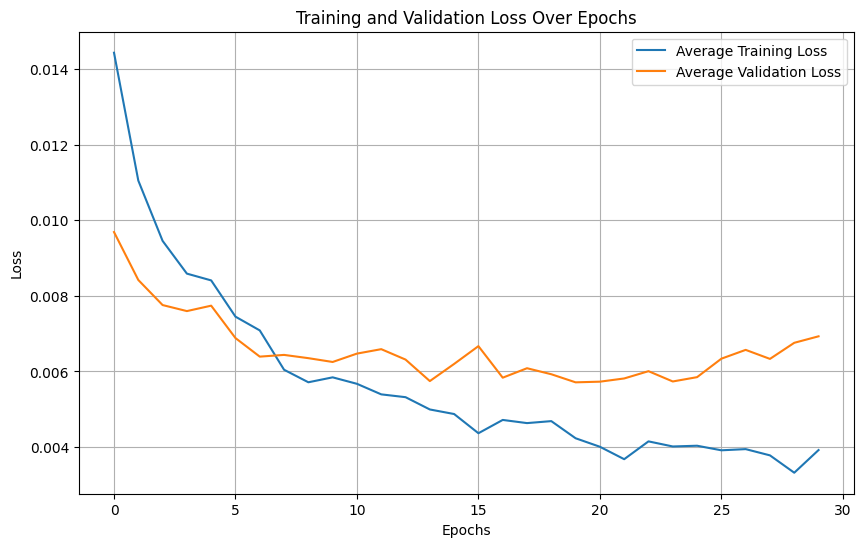

In [ ]:
# Extract the first and third columns
train_losses = [item[0] for item in history]
valid_losses = [item[2] for item in history]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Average Training Loss')
plt.plot(valid_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png') # Saves the plot as an image file
plt.show() # Displays the plot

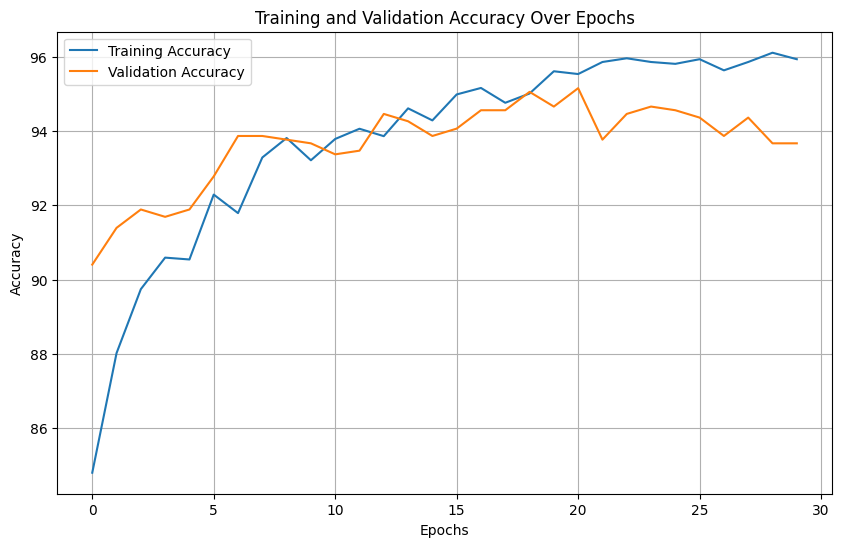

In [ ]:
# Extract the first and third columns
train_accuracy = [item[1] for item in history]
valid_accuracy = [item[3] for item in history]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png') # Saves the plot as an image file
plt.show() # Displays the plot

In [ ]:
# Load the best saved model during training.
model = torch.load("best_model.pt", weights_only=False)

### Inference

* Since we dont have a testing set we directly perform inference from the best saved model

In [ ]:
def predict(model, test_image_name):
    """
    Predicts the class of a given test image using a trained model.

    Parameters:
    model (torch.nn.Module): The trained model to use for prediction.
    test_image_name (str): The file path of the test image.

    The function loads the image, applies necessary transformations, and
    passes it through the model to get the top 3 predictions with their confidence scores.
    """
    # Applies the predefined transformation pipeline for test images
    transform = common_transform

    test_image = Image.open(test_image_name)

    # Creates a figure to visualize the test image
    plt.figure(figsize=(10, 7))
    plt.imshow(test_image)  # Displays the test image before applying transformations
    plt.axis('off')  # Removes the axis for a cleaner image visualization

    # Apply transformations and reshape to fit model input
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)  # Reshape for batch processing

    # Checks if a GPU is available and moves the tensor to CUDA if possible
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()

    with torch.no_grad():  # Disables gradient computation to optimize inference performance
        model.eval()  # Set model to evaluation mode
        out = model(test_image_tensor)  # Get model predictions
        ps = torch.exp(out)  # Convert log probabilities to actual probabilities becuase we used LogSoftmax at Final Layers

        # Extract the top 3 predictions and their probabilities
        topk, topclass = ps.topk(3, dim=1)
        cls = class_mapping[topclass.cpu().numpy()[0][0]]  # Get the top predicted class
        score = topk.cpu().numpy()[0][0]  # Get the top prediction confidence score

        # Print the top 3 predictions with their confidence scores
        for i in range(3):
            print(f"Prediction {i+1}: {class_mapping[topclass.cpu().numpy()[0][i]]}",
                  f"Score: {topk.cpu().numpy()[0][i]*100:.3f}%")

In [ ]:
# The model can be tested as follows
# predict(model,'sunflower.jpg')